In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.patches import Patch
from scipy.stats import linregress

import scanpy as sc
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import fdrcorrection
import umap
import networkx as nx
#import many
from network import nx_plot 

In [2]:
PALETTE = {
            'B cell':"#588B8B",
            'CD4+ T cell':"#FFD5C2", 
           'CD14+ monocyte':"#F28F3B", 'CD16+ monocyte':"#C8553D",
       'Cytotoxic T cell':"#2D3047", 'Dendritic cell':"#93B7BE", 'Megakaryocyte':"#eef2f3"
           
          }

In [3]:
def plot_per_celltype(df_metrics_tot,
                    method,
                    savename,
                    metrics,
                    ):

    start_color = '#FF6B35'
    end_color = '#FFFFFF'

    palette = ["#272300","#443F1C","#746E48","#A9A179","#CDC392","#E8E5DA","#9EB7E5","#648DE5","#304C89"]#, "#08336D"]
    xolorr = "#677CBF"#'#A02c5a'#"#27C196"#"#304C89"
    cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
    colors = [start_color, end_color]
    cmap = LinearSegmentedColormap.from_list('my_cmap', palette)

    # Convert colormap to seaborn palette
    n_colors = np.linspace(1,0.1,9)  # Number of colors in the palette
    palette = [cmap(it) for it in n_colors]
    fig, axes = plt.subplots(1,len(metrics), figsize=(18,6))
    axes = axes.flatten()
    sns.set(font_scale=2, style="white")
    fontsize=18
    #tmp_method = "RandomForestRegressor"
    tmp_method = method
    df_tmp = df_metrics_tot[df_metrics_tot.method ==tmp_method]
    sns.set(style="white", font_scale=2)
    for indx, it in enumerate(metrics):
        tmp = df_tmp[df_tmp.metrics==it].groupby(["celltype","individualID", "fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,x="celltype",
                hue="celltype",
                y="res", palette=palette,
                ax=ax,
                showmeans=True,
                dodge=False,
                   showfliers = False, 
                boxprops={'facecolor':'none', 'edgecolor':xolorr},
                meanprops={"marker":"o",
                    "markerfacecolor":xolorr,
                    "markeredgecolor":xolorr,
                    "markersize":"5"},
                medianprops={'color':xolorr},
    whiskerprops={'color':xolorr},
    capprops={'color':xolorr},
                flierprops={"markerfacecolor":xolorr, "markeredgecolor":xolorr},
                linewidth=0.8)#, notch=True)
        means = tmp.groupby(['celltype'])['res'].median().round(2)
        vertical_offset = tmp['res'].median() * 0.01 # offset from median for display
        print(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        # for xtick in ax.get_xticks():
        #     ax.text(xtick,
        #             means[xtick] + vertical_offset,
        #             means[xtick], 
        #             horizontalalignment='center',
        #             size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        ax.set_title(it)
        ax.set_ylabel("")
       # ax.set_ylim(0,1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.legend().remove()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savename + "box_comp_CV_CELLTYPE.svg",
                bbox_inches="tight")
   # plt.close("all")

def plot_per_fold(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","assay"]).res.mean().reset_index()
        ax = axes[indx]
        sns.swarmplot(data=tmp,y="res",
                hue="celltype",
                x="assay", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                # showfliers = True,
                # showmeans=True,
                # dodge=True,
                     # width=1,
                # meanprops={"marker":"o",
                #     "markerfacecolor":"black",
                #     "markeredgecolor":"black",
                #     "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["assay"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.1 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_fold_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")



def plot_model_sub(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method", "individualID","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = False,
                showmeans=True,
                dodge=False,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_per_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")
def plot_model_genes(df_metrics_tot, metrics,savename, palette=None, thresh=0.2):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method","genes","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = False,
                showmeans=True,
                dodge=True,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
            # ax.axhline(y=thresh, c="k", linestyle="--")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
      
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_genes_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")
def plot_model_it(df_metrics_tot, metrics,savename, palette=None):
    fig, axes = plt.subplots(1,len(metrics), figsize=(15,4))
    axes = axes.flatten()
    com = df_metrics_tot.method.unique()
    print(com)

    #hue_order=["Cellformer", "NMF", "KNN"]

    sns.set(font_scale=2, style="white")
    fontsize=18
    for indx, it in enumerate(metrics):
        tmp = df_metrics_tot[df_metrics_tot.metrics==it].groupby(["celltype","method","fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,y="res",
                # hue="celltype",
                x="celltype", 
                    palette=palette,
                #hue_order=hue_order,
                #order=hue_order,
                ax=ax,
                showfliers = False,
                showmeans=True,
                dodge=True,
                     # width=1,
                meanprops={"marker":"o",
                    "markerfacecolor":"black",
                    "markeredgecolor":"black",
                    "markersize":"5"},
                linewidth=0.8)#, notch=True)
        # annotator = Annotator(ax, pairs, data=tmp,
        #                    y="res",
        #                    x="method",
        #                    hue="method",
        #                    hue_order=hue_order,
        #                    order=hue_order,
        #                         )
        # annotator.configure(test='Mann-Whitney',  text_format="star", 
        #                    loc='inside', fontsize="20", 
        #                    comparisons_correction="BH")
        # annotator.apply_and_annotate()
        # ax.legend("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), 
                       fontsize=fontsize)
        means = tmp.groupby(["celltype"])['res'].mean().round(2)
        vertical_offset = tmp['res'].mean() * 0.02 # offset from median for display
        # if "mse"in it:
        #     ax.set_yscale("log")
        for xtick in ax.get_xticklabels():
            lab = xtick.get_text()
            print(lab)
            pos = xtick.get_position()[0]
            ax.text(pos,
                    means.loc[lab] + vertical_offset,
                    means.loc[lab], 
                    horizontalalignment='center',
                    size='x-small',color='black',weight='semibold')
        ax.set_xlabel("")
        # ax.set_title(it)
        if "mse" in it:
            ax.set_yscale("log")
            ax.set_title("MSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=20)
        ax.legend().remove()
    plt.savefig(savename + "box_CV_per_sub_it_ct.svg",
                bbox_inches="tight")
    # if show:
    plt.show()
    plt.close("all")

In [4]:
savepath = "/home/eloiseb/data/rna/pbmc_24/"
if not os.path.exists(savepath):
    os.mkdir(savepath)

In [5]:
map_fold2ind = {}#ff:ii for ff,ii in zip(df_metrics["fold"].values, df_metrics["individualID"].values)}
map_fold2ind["fold_0"] = "10X"
map_fold2ind["fold_1"] = "Celseq"
map_fold2ind["fold_2"] = "Drop/inDrop"
map_fold2ind["fold_3"] = "Seqwell"


['Cellformer']


/tmp/ipykernel_3018292/3319000314.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell


/tmp/ipykernel_3018292/3319000314.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell


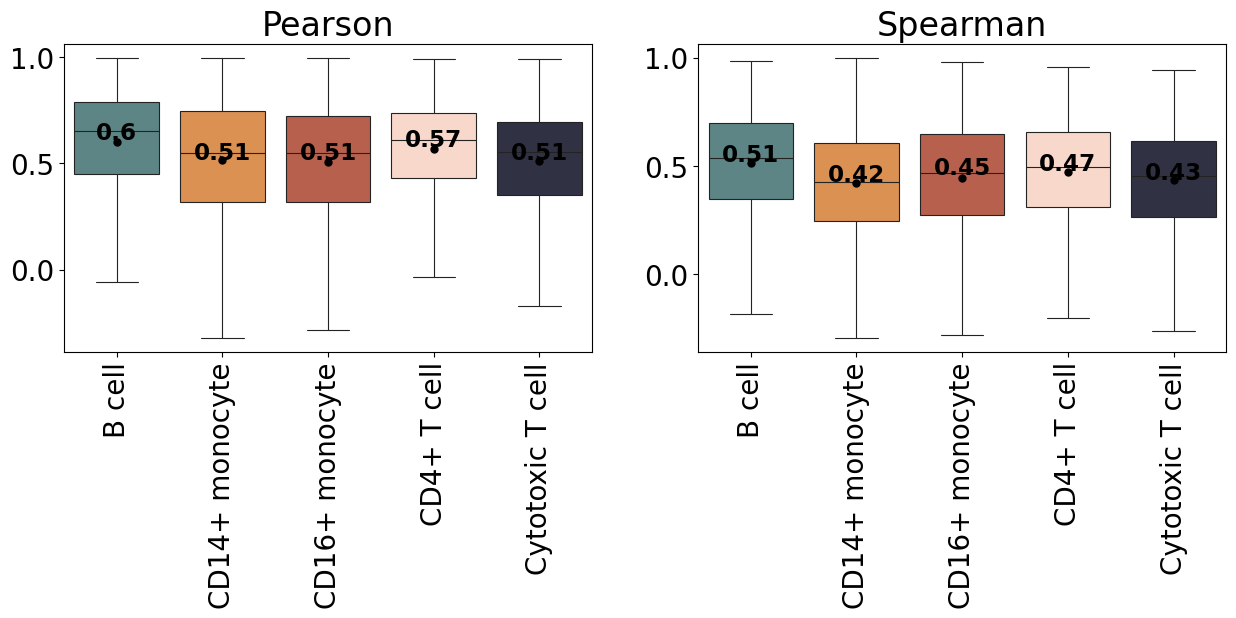

/tmp/ipykernel_3018292/3319000314.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3018292/3319000314.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Cellformer']
B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell
B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell


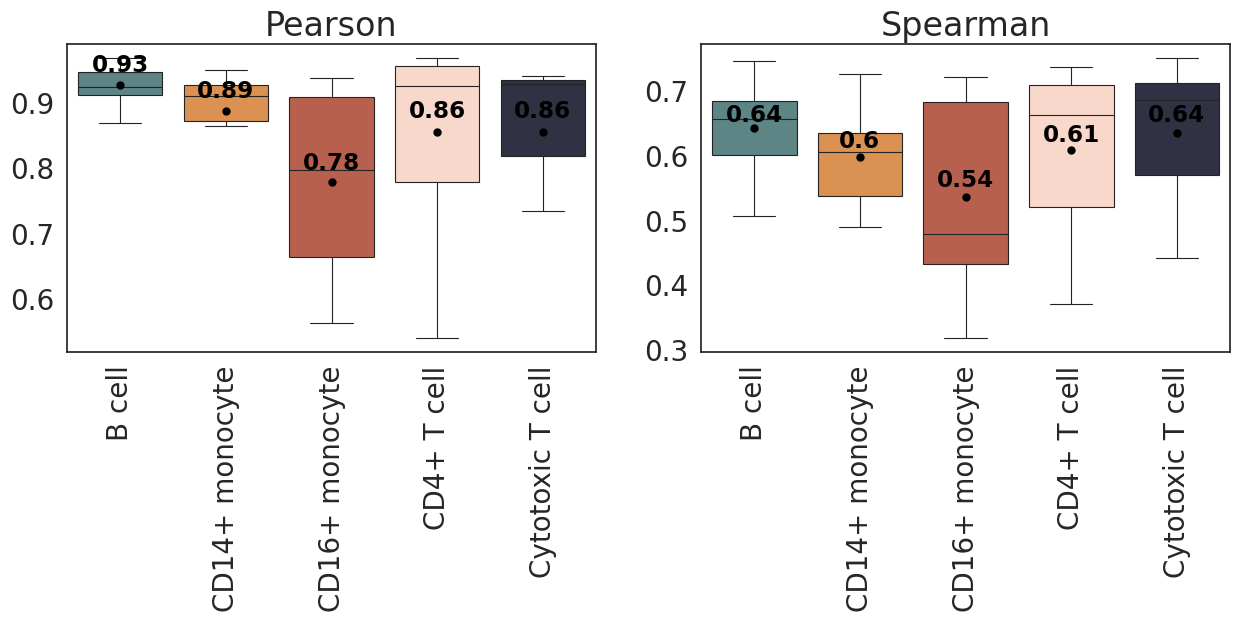

['Cellformer']
10X
Celseq
Drop/inDrop
Seqwell
10X
Celseq
Drop/inDrop
Seqwell


/tmp/ipykernel_3018292/3319000314.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
/tmp/ipykernel_3018292/3319000314.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),


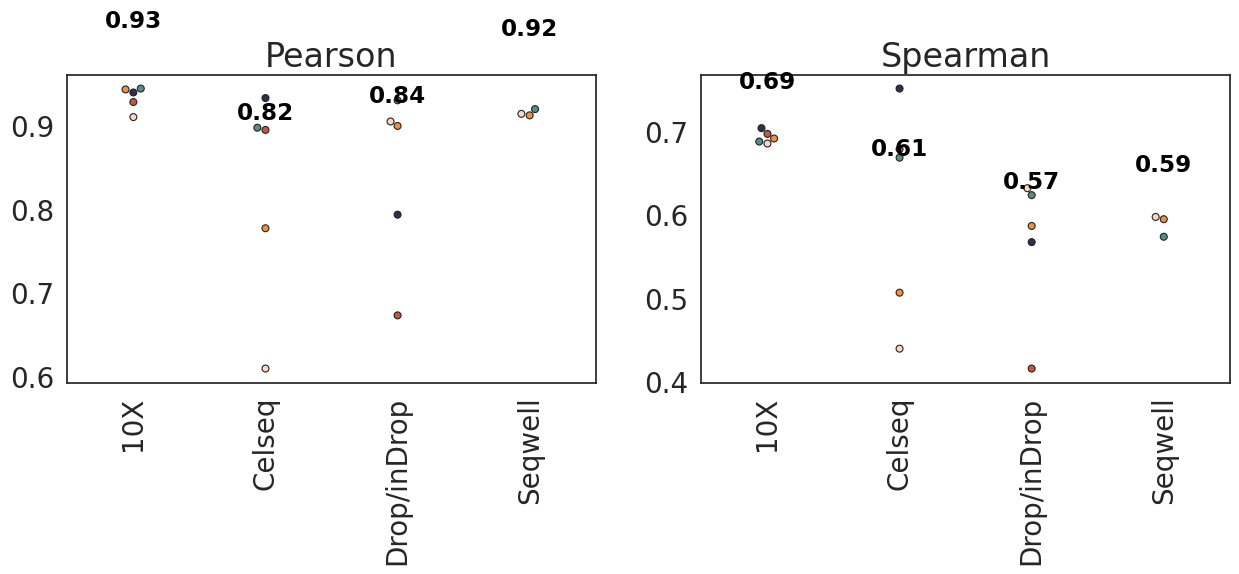

In [9]:
model = "/remote/home/eloiseb/experiments/deconv_rna/pbmc_logo_5/"
met = model + "metrics_all_genes.csv"
df_metrics = pd.read_csv(met)

df_metrics = df_metrics[~df_metrics.res.isna()]

df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_genes(df_metrics,metrics, savepath+"logo_", palette=PALETTE, thresh=0.)

# met = model + "metrics_all_it.csv"
# df_metrics = pd.read_csv(met)
df_metrics = df_metrics[~df_metrics.res.isna()]
# df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
# df_metrics["method"] = "Cellformer"
# metrics=[ "pearson", "spearman"]
# plot_model_it(df_metrics,metrics, savepath, palette=PALETTE)

met = model + "metrics_all_sub.csv"
df_metrics = pd.read_csv(met)
df_metrics = df_metrics[~df_metrics.res.isna()]
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_sub(df_metrics,metrics, savepath+"logo_", palette=PALETTE)
df_metrics["assay"] = df_metrics["fold"].map(map_fold2ind)
plot_per_fold(df_metrics,metrics, savepath+"logo_", palette=PALETTE)


In [10]:
df_metrics[df_metrics.metrics=="spearman"].groupby(["celltype", "fold"]).res.mean()

celltype          fold  
B cell            fold_0    0.687763
                  fold_1    0.668504
                  fold_2    0.623585
                  fold_3    0.573724
CD14+ monocyte    fold_0    0.691440
                  fold_1    0.506781
                  fold_2    0.586662
                  fold_3    0.594759
CD16+ monocyte    fold_0    0.696955
                  fold_1    0.678630
                  fold_2    0.415868
CD4+ T cell       fold_0    0.685421
                  fold_1    0.439693
                  fold_2    0.631894
                  fold_3    0.597466
Cytotoxic T cell  fold_0    0.703804
                  fold_1    0.751253
                  fold_2    0.567323
Name: res, dtype: float64

['Cellformer']


/tmp/ipykernel_3018292/3319000314.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell


/tmp/ipykernel_3018292/3319000314.py:269: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell


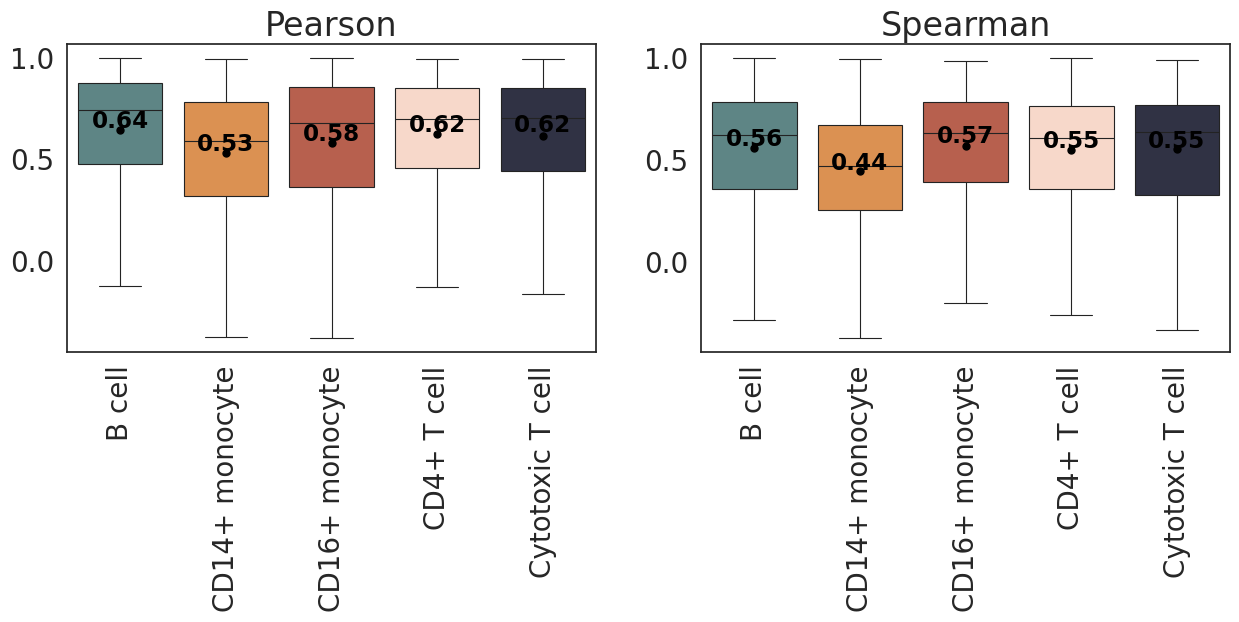

/tmp/ipykernel_3018292/3319000314.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3018292/3319000314.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Cellformer']
B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell
B cell
CD14+ monocyte
CD16+ monocyte
CD4+ T cell
Cytotoxic T cell


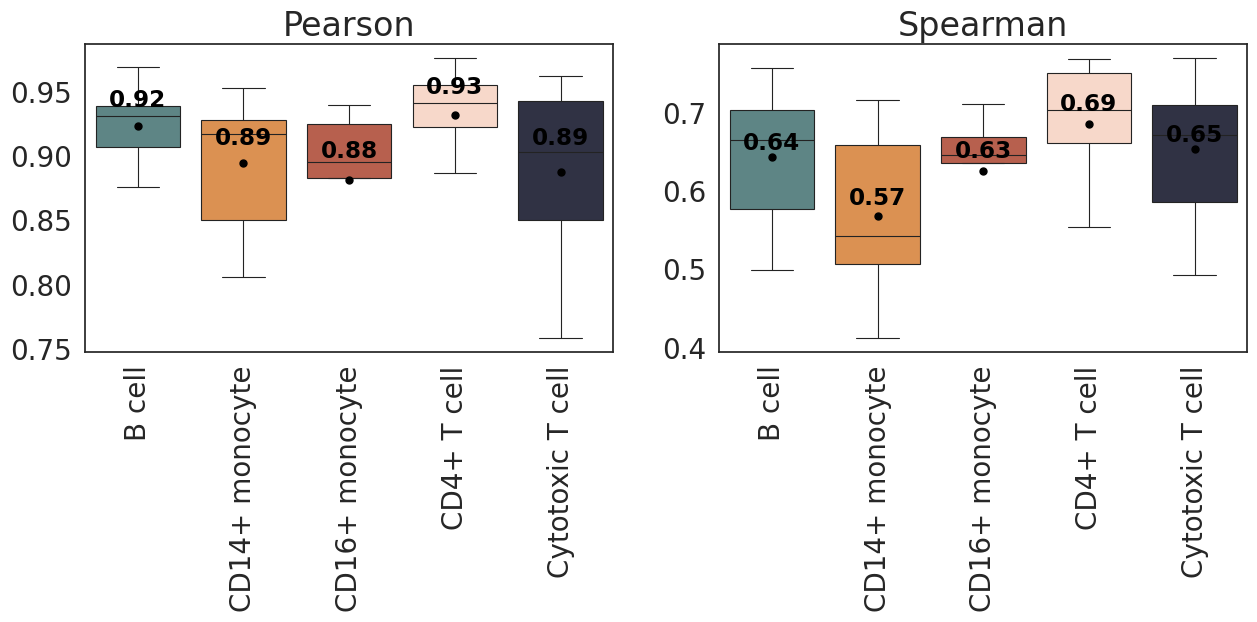

In [13]:
model = "/remote/home/eloiseb/experiments/deconv_rna/pbmc_kfold_5/"
met = model + "metrics_all_genes.csv"
df_metrics = pd.read_csv(met)

df_metrics = df_metrics[~df_metrics.res.isna()]

df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_genes(df_metrics,metrics, savepath+"kfold_", palette=PALETTE, thresh=0.)

# met = model + "metrics_all_it.csv"
# df_metrics = pd.read_csv(met)
df_metrics = df_metrics[~df_metrics.res.isna()]
# df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
# df_metrics["method"] = "Cellformer"
# metrics=[ "pearson", "spearman"]
# plot_model_it(df_metrics,metrics, savepath, palette=PALETTE)

met = model + "metrics_all_sub.csv"
df_metrics = pd.read_csv(met)
df_metrics = df_metrics[~df_metrics.res.isna()]
df_metrics= df_metrics.replace({"ENDO-Mural":"Endo-Mural"})
df_metrics["method"] = "Cellformer"
metrics=[ "pearson", "spearman"]
plot_model_sub(df_metrics,metrics, savepath+"kfold_", palette=PALETTE)